# Final Project Notebook

In [1]:
import os
import mlflow
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class_labels = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons',
}

## Loading datasets

In [3]:
#!wget -P ../data https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
#!wget -P ../data https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip

In [4]:
BASE_PATH = '../data/GTSRB'
TRAIN_PATH = BASE_PATH + '/Training'
TEST_PATH = BASE_PATH + '/Online-Test-sort'

BATCH_SIZE = 32
IMAGE_SIZE = 150

### Checking dataset distribution

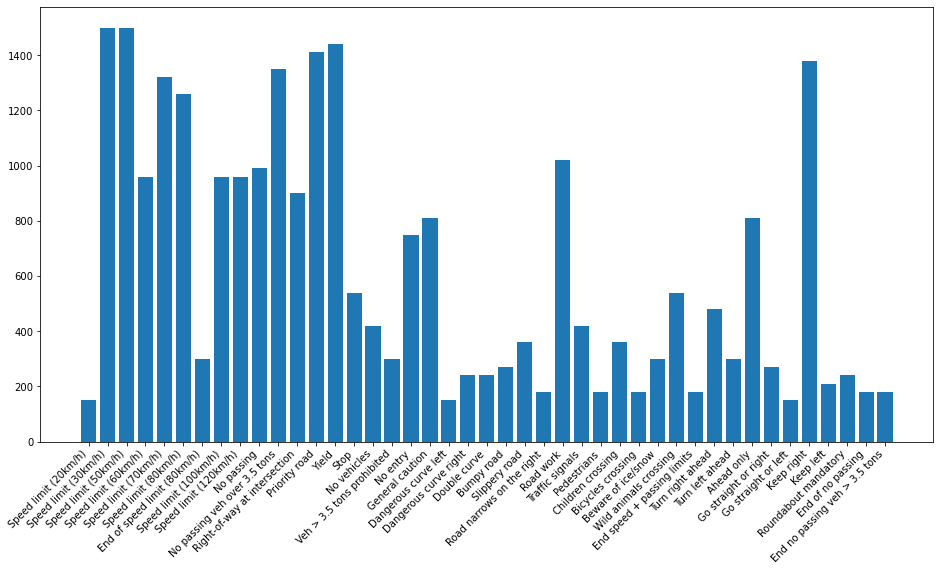

In [7]:
# Adapted from https://www.kaggle.com/code/zhuhaibin/read-data-from-gtsrb
folders = [name for name in os.listdir(TRAIN_PATH) if os.path.isdir(TRAIN_PATH + "/" + name)]

class_size = []
classes = []

for folder in folders:
    train_files = os.listdir(TRAIN_PATH + '/' + folder)
    class_size.append(len(train_files) - 1) # each folder has a .csv inside so - 1
    classes.append(class_labels[int(folder)])

# Plotting the number of images in each class
plt.figure(figsize=(16, 8))  
plt.bar(classes, class_size)
plt.xticks(classes, rotation=45, ha="right")
plt.show()

In [8]:
train_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    cval=0.0,
    rescale=1./255,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=123,
    subset="training",
)

validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rescale=1./255,
    validation_split=0.2,
)

validation_generator = validation_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=123,
    subset="validation",
)

Found 21312 images belonging to 43 classes.
Found 5328 images belonging to 43 classes.


### Seeing some example augmentations

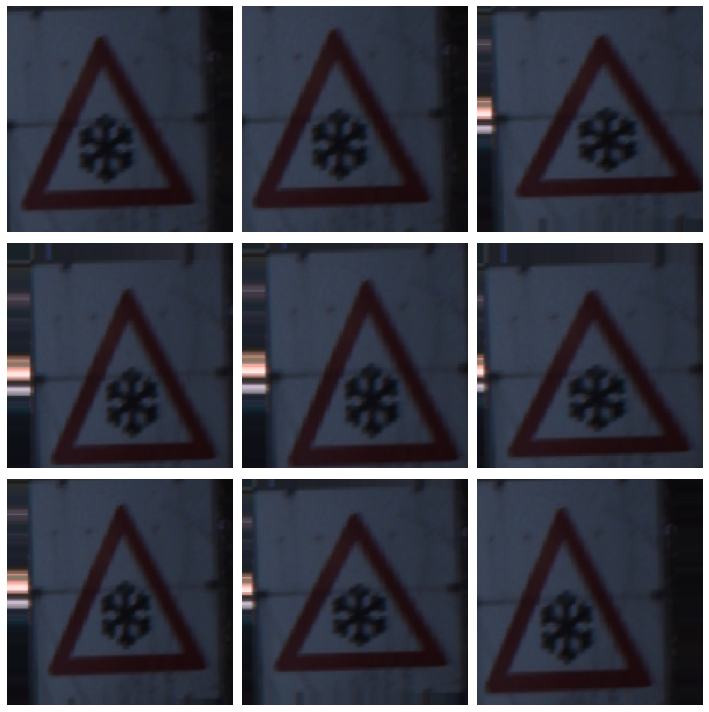

In [9]:
images = [train_generator[0][0][0] for i in range(9)]

fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Building Network

In [12]:
# base_model = tf.keras.applications.EfficientNetB0(
base_model = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling=None,
    classes=len(class_labels),
    classifier_activation="softmax",
)

model_name=base_model.name

base_model.trainable = False
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']   

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 38, 38, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 19, 19, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 21, 21, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 19, 19, 128)  147456      ['conv3_block5_2_pad[0][0]']     
                                                                                                  
 conv3_blo

 conv3_block8_preact_bn (BatchN  (None, 19, 19, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 19, 19, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 19, 19, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_block8_1_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block8_1_conv[0][0]']    
 ization) 

 conv4_block2_2_pad (ZeroPaddin  (None, 12, 12, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 10, 10, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 10, 10, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 10, 10, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block7_out (Add)         (None, 10, 10, 1024  0           ['conv4_block6_out[0][0]',       
                                )                                 'conv4_block7_3_conv[0][0]']    
          

                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 10, 10, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block13_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block13_preact_bn[0][0]']
 ivation)                       )                                                                 
          

                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block15_2_bn[0][0]']     
 on)      

 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block18_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block18_1_conv[0][0]']   
 lization)                                                                                        
          

 conv4_block20_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block20_out (Add)        (None, 10, 10, 1024  0           ['conv4_block19_out[0][0]',      
          

                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block23_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block23_1_relu[0][0]']   
 ng2D)                                                                                            
          

 conv4_block25_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 10, 10, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block26_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block26_preact_bn[0][0]']
 ivation) 

 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block31_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block33_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block36_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block36_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block36_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 5, 5, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 5, 5, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 5, 5, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalizat

In [13]:
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(len(class_labels))(x)
model = keras.Model(inputs, outputs)

### Training Network

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_delta=1e-4,
    min_lr=0.001,
)

In [ ]:
mlflow.keras.autolog()
mlflow.log_param("model", model_name)
    
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
model.fit(
    train_generator, 
    epochs=20, 
    callbacks=[early_stopping, reduce_lr], 
    validation_data=validation_generator,
)

2022/09/11 04:55:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.


Epoch 1/20
  7/666 [..............................] - ETA: 1:10 - loss: 4.0177 - accuracy: 0.0491

## Test results

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)